<a href="https://colab.research.google.com/github/vintagedeek/clinical_trials_nih/blob/master/capstone_colab_2020_09_24_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from torchtext import data, datasets, vocab
import torch
from torch import nn
import torch.nn.functional as F

import spacy

from collections import OrderedDict, namedtuple
from itertools import product
import time

import random, math
import tqdm, sys

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive

"2016 - Evan's 3rd Birthday"
 ACCP
'Colab Notebooks'
 DSC_0148.JPG
 DSC_0162.JPG
 DSC_0164.JPG
 DSC_0166.JPG
 DSC_0168.JPG
 DSC_0176.JPG
 DSC_0196.JPG
 DSC_0199.JPG
 DSC_0210.JPG
 DSC_0231.JPG
 DSC_0246.JPG
 DSC_0251.JPG
 DSC_0264.JPG
 DSC_0265.JPG
 DSC_0266.JPG
 DSC_0270.JPG
 DSC_0274.JPG
 DSC_0275.JPG
 DSC_0304.JPG
 DSC_0310.JPG
 DSC_0312.JPG
 DSC_0317.JPG
 DSC_0318.JPG
 DSC_0320.JPG
 DSC_0321.JPG
'family_health_data_based_on_relation_to_aunt_sandie_2020_07_08 (1).gsheet'
 family_health_data_based_on_relation_to_aunt_sandie_2020_07_08.gsheet
 final_2019_ascending.mp4
 Image-1.jpg
 IMG_6232.jpg
 IMG_6892.jpg
 MidwesternTranscriptGriffing.gdoc
 MidwesternTranscriptGriffing.pdf
'Mortgage Suntrust'
 savannah_cutest_laugh_6mo.MOV
 test_colab.csv
 train_colab.csv
'Untitled spreadsheet.gsheet'
 val_colab.csv


In [ ]:
!ls /content

drive  gdrive  sample_data


In [ ]:
train_url1 = 'https://raw.githubusercontent.com/vintagedeek/clinical_trials_nih/master/data_capstone/train1.csv'
train_url2 = 'https://raw.githubusercontent.com/vintagedeek/clinical_trials_nih/master/data_capstone/train2.csv'
train_url3 = 'https://raw.githubusercontent.com/vintagedeek/clinical_trials_nih/master/data_capstone/train3.csv'

In [ ]:
df_train1 = pd.read_csv(train_url1)
df_train2 = pd.read_csv(train_url2)
df_train3 = pd.read_csv(train_url3)
df_train = pd.concat([df_train1, df_train2, df_train3])
len(df_train)

131562

In [ ]:
df_train.to_csv('train_colab.csv', index=False)

In [ ]:
val_url = 'https://raw.githubusercontent.com/vintagedeek/clinical_trials_nih/master/data_capstone/val.csv'
test_url = 'https://raw.githubusercontent.com/vintagedeek/clinical_trials_nih/master/data_capstone/test.csv'
df_val = pd.read_csv(val_url)
df_test = pd.read_csv(test_url)
df_val.to_csv('val_colab.csv', index=False)
df_test.to_csv('test_colab.csv', index=False)

# Tokenize Text

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in nlp.tokenizer(text)] # tok.text returns the string of each word; otherwise just having tok would give a type == spacy.tokens.token.Token

In [ ]:
TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False, use_vocab=True) # use_vocab when labels are strings. set use_vocab=False if labels are already integers.

In [ ]:
train, val, test = data.TabularDataset.splits(path='gdrive/My Drive/', train='train_colab.csv', validation='val_colab.csv', 
                                              test='test_colab.csv', format='csv', fields=[('text', TEXT), ('units_clean', LABEL)],
                                              skip_header=True)

# Word embeddings? (don't think...seems to happen in model

In [ ]:
TEXT.build_vocab(train, max_size=50_000 - 2) # 50000 is vocab size - minus 2 to make space for <unk> and <pad>
LABEL.build_vocab(train)

# Batching Process

In [ ]:
# Replaced PB code with code from link
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=4, device=device,
                                                  sort_key=lambda x: len(x.text), #  https://github.com/pytorch/text/issues/474
                                                  sort_within_batch=False) # per link above, False bc w want to wrap this Iterator layer. 

In [ ]:
mx = 512 # mx is max length, Peter Bloem set to 512

# Peter Bloem Self Attention

In [ ]:
class SelfAttentionWide(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)

class SelfAttentionNarrow(nn.Module):

    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads
        self.mask = mask

        s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(s, s, bias=False)
        self.toqueries = nn.Linear(s, s, bias=False)
        self.tovalues  = nn.Linear(s, s, bias=False)

        self.unifyheads = nn.Linear(heads * s, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h
        x = x.view(b, t, h, s)

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        assert keys.size() == (b, t, h, s)
        assert queries.size() == (b, t, h, s)
        assert values.size() == (b, t, h, s)

        # Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        return self.unifyheads(out)

# Peter Bloem Transformer Block

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()

        self.attention = SelfAttentionWide(emb, heads=heads, mask=mask) if wide \
                    else SelfAttentionNarrow(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

# Peter Bloem Classification Transformer Class

In [ ]:
class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout, wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        x = tokens + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)

In [ ]:
device

'cuda'

In [ ]:
model = CTransformer(emb=128, heads=8, depth=6, seq_length=mx, num_tokens=50000, num_classes=20, max_pool=True) # mx default 512
model = model.to(device)

In [ ]:
opt = torch.optim.Adam(lr=0.0001, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (10_000 / 4), 1.0))

In [ ]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
seen = 0
nb_classes = 20
confusion_matrix = torch.zeros(nb_classes, nb_classes)
num_epochs = 11

preds = np.zeros(0) # creates empty array for F1 score
lab = np.zeros(0) # creates empty array for F1 score

for e in range(num_epochs): # epochs

    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_iter):

        opt.zero_grad()

        input = batch.text[0].to(device)
        label = (batch.units_clean - 1).to(device)
        
        if input.size(1) > mx:
            input = input[:, :mx]
        out = model(input)
        loss = F.nll_loss(out, label)

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if 1.0 > 0.0: # gradient_clipping arg default=1.0
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)

    with torch.no_grad():
      
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in val_iter:

            input = batch.text[0].to(device)
            label = (batch.units_clean - 1).to(device)
            
            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label == out).sum().item())
            
            if e == num_epochs - 1:
                for t, p in zip(label.view(-1), out.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                
                preds = np.append(preds, out.cpu().numpy())
                lab = np.append(lab, label.cpu().numpy())

        acc = cor / tot
        print(f'-- {"validation"} accuracy {acc:.3}')

  0%|          | 0/32891 [00:00<?, ?it/s]


 epoch 0


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.866

 epoch 1


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.884

 epoch 2


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.891

 epoch 3


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.901

 epoch 4


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.904

 epoch 5


  0%|          | 1/32891 [00:00<1:46:30,  5.15it/s]

-- validation accuracy 0.906

 epoch 6


  0%|          | 1/32891 [00:00<1:47:55,  5.08it/s]

-- validation accuracy 0.907

 epoch 7


  0%|          | 1/32891 [00:00<1:48:41,  5.04it/s]

-- validation accuracy 0.902

 epoch 8


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.907

 epoch 9


  0%|          | 1/32891 [00:00<1:48:45,  5.04it/s]

-- validation accuracy 0.91

 epoch 10


100%|██████████| 32891/32891 [14:52<00:00, 36.87it/s]


-- validation accuracy 0.906


# 91 percent accuracy - first run original params
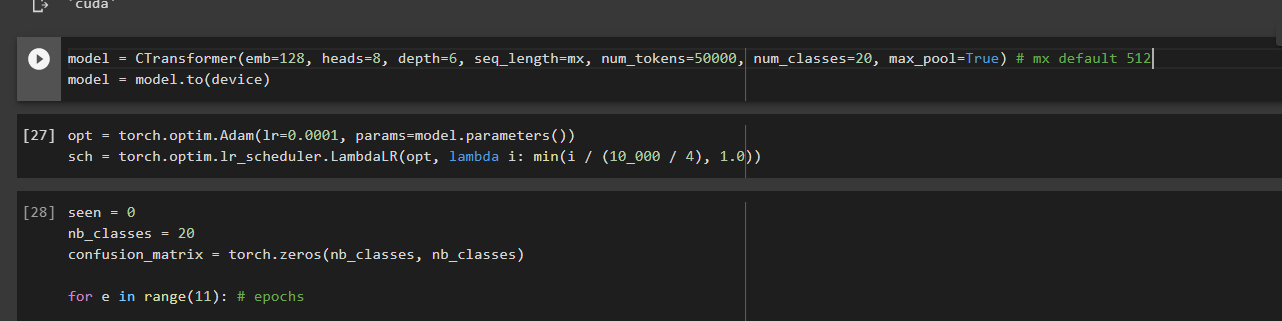

In [ ]:
print_cm(confusion_matrix, labels=LABEL.vocab.itos[1:])

                                             participants           units on a scale percentage of participants                     months                       days             percent change                      hours                      ng/ml                      mg/dl                       mmhg                     liters                      ratio                    minutes                 percentage                         mm                     titers                      pg/ml                     mmol/l                      weeks                    seconds 
                  participants                     4360.0                       62.0                      236.0                       10.0                        7.0                        5.0                        6.0                       14.0                       19.0                        1.0                        4.0                        4.0                        0.0                        2.0                    

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(lab, preds, average='macro'))
print(f1_score(lab, preds, average='micro'))
print(f1_score(lab, preds, average='weighted'))

0.811664646354368
0.9060682766641581
0.9042233619076105


In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix.numpy(), columns=LABEL.vocab.itos[1:], index=LABEL.vocab.itos[1:])
confusion_matrix_df.to_csv('confusion_matrix_v2_wideSA_2020_09_29.csv', index=True)

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

token_embedding.weight 	 torch.Size([50000, 128])
pos_embedding.weight 	 torch.Size([512, 128])
tblocks.0.attention.tokeys.weight 	 torch.Size([16, 16])
tblocks.0.attention.toqueries.weight 	 torch.Size([16, 16])
tblocks.0.attention.tovalues.weight 	 torch.Size([16, 16])
tblocks.0.attention.unifyheads.weight 	 torch.Size([128, 128])
tblocks.0.attention.unifyheads.bias 	 torch.Size([128])
tblocks.0.norm1.weight 	 torch.Size([128])
tblocks.0.norm1.bias 	 torch.Size([128])
tblocks.0.norm2.weight 	 torch.Size([128])
tblocks.0.norm2.bias 	 torch.Size([128])
tblocks.0.ff.0.weight 	 torch.Size([512, 128])
tblocks.0.ff.0.bias 	 torch.Size([512])
tblocks.0.ff.2.weight 	 torch.Size([128, 512])
tblocks.0.ff.2.bias 	 torch.Size([128])
tblocks.1.attention.tokeys.weight 	 torch.Size([16, 16])
tblocks.1.attention.toqueries.weight 	 torch.Size([16, 16])
tblocks.1.attention.tovalues.weight 	 torch.Size([16, 16])
tblocks.1.attention.unifyheads.weight 	 torch.Size([128, 128])
tblocks.1.attention.unifyhea

In [ ]:
torch.save(model.state_dict(), 'clin_trials_unit_model_v2_2020_09_29_narrow_sa.pt')

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|         token_embedding.weight        |  6400000   |
|          pos_embedding.weight         |   65536    |
|   tblocks.0.attention.tokeys.weight   |    256     |
|  tblocks.0.attention.toqueries.weight |    256     |
|  tblocks.0.attention.tovalues.weight  |    256     |
| tblocks.0.attention.unifyheads.weight |   16384    |
|  tblocks.0.attention.unifyheads.bias  |    128     |
|         tblocks.0.norm1.weight        |    128     |
|          tblocks.0.norm1.bias         |    128     |
|         tblocks.0.norm2.weight        |    128     |
|          tblocks.0.norm2.bias         |    128     |
|         tblocks.0.ff.0.weight         |   65536    |
|          tblocks.0.ff.0.bias          |    512     |
|         tblocks.0.ff.2.weight         |   65536    |
|          tblocks.0.ff.2.bias          |    128     |
|   tblock

7365140

In [ ]:
model

CTransformer(
  (token_embedding): Embedding(50000, 128)
  (pos_embedding): Embedding(512, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttentionNarrow(
        (tokeys): Linear(in_features=16, out_features=16, bias=False)
        (toqueries): Linear(in_features=16, out_features=16, bias=False)
        (tovalues): Linear(in_features=16, out_features=16, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttentionNarrow(
        (tokeys): Linear(in_features=16, out_features=16, bias=False)
       

# Demonstrating model on mini test sample

In [ ]:
import pandas as pd

class DataFrameDataset(data.Dataset):
     """Class for using pandas DataFrames as a datasource"""
     def __init__(self, examples, fields, filter_pred=None):
         """
         Create a dataset from a pandas dataframe of examples and Fields
         Arguments:
             examples pd.DataFrame: DataFrame of examples
             fields {str: Field}: The Fields to use in this tuple. The
                 string is a field name, and the Field is the associated field.
             filter_pred (callable or None): use only exanples for which
                 filter_pred(example) is true, or use all examples if None.
                 Default is None
         """
         self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
         if filter_pred is not None:
             self.examples = filter(filter_pred, self.examples)
         self.fields = dict(fields)
         # Unpack field tuples
         for n, f in list(self.fields.items()):
             if isinstance(n, tuple):
                 self.fields.update(zip(n, f))
                 del self.fields[n]

class SeriesExample(data.Example):
     """Class to convert a pandas Series to an Example"""
    
     @classmethod
     def fromSeries(cls, data, fields):
         return cls.fromdict(data.to_dict(), fields)

     @classmethod
     def fromdict(cls, data, fields):
         ex = cls()
         
         for key, field in fields.items():
             if key not in data:
                 raise ValueError("Specified key {} was not found in "
                 "the input data".format(key))
             if field is not None:
                 setattr(ex, key, field.preprocess(data[key]))
             else:
                 setattr(ex, key, data[key])
         return ex

In [ ]:
fields = { 'mini_unit' : LABEL, 'mini_text' : TEXT } 

In [ ]:
my_df = pd.DataFrame({'mini_unit': ['units on a scale', 'months', 'ng/ml', 'participants', 'mmhg'], 
                      'mini_text': ['We used Likert scale with questions on happiness.',
                                    'This study will measure the time until death for people with colon cancer stage IV after being treated chemotherapy.',
                                    'Concentration (Steady State) of Imatinib During Cycle One (Pharmacokinetics) Blood collected before and at 1,2,4 ad 24 hours after ingestion of imatinib on day 8 of cycle 1 result is the measurement of the before dosing on day 8 (trough level) and the 24 hour dosing day 8',
                                    'Measure how many participants were counted in the control versus treated group',
                                    'We will report the blood pressure.']})

In [ ]:
test_ds = DataFrameDataset(my_df, fields)

In [ ]:
mini_test_iter = data.BucketIterator(test_ds, batch_size=1, device=device, sort_key=lambda x: len(x.mini_text), #  https://github.com/pytorch/text/issues/474
                                     train=False,
                                     sort_within_batch=False) # per link above, False bc w want to wrap this Iterator layer. 

In [ ]:
my_df['len_text'] = my_df['mini_text'].apply(lambda x: len(x.split(' ')))

In [ ]:
my_df

,mini_unit,mini_text,len_text
0,units on a scale,We used Likert scale with questions on happiness.,8
1,months,This study will measure the time until death f...,19
2,ng/ml,Concentration (Steady State) of Imatinib Durin...,48
3,participants,Measure how many participants were counted in ...,12
4,mmhg,We will report the blood pressure.,6


In [ ]:
nb_classes = 20
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
      
        model.train(False)
        for batch in mini_test_iter:

            input = batch.mini_text[0].to(device)
            #print(input)
            label = (batch.mini_unit - 1).to(device)
            print(label)
            if input.size(1) > mx:
                input = input[:, :mx]
            #out = model(input).argmax(dim=1) # .cpu().numpy() to get array
            print(torch.exp(model(input)))
            # print(out)

            #for t, p in zip(label.view(-1), out.view(-1)):
                #confusion_matrix[t.long(), p.long()] += 1

tensor([9], device='cuda:0')
tensor([[1.7762e-06, 2.6359e-11, 5.9104e-09, 2.9026e-11, 1.2369e-09, 1.7075e-09,
         1.1313e-09, 7.3491e-08, 1.6109e-07, 1.0000e+00, 1.7226e-10, 6.5069e-08,
         1.8982e-10, 2.7818e-09, 6.0258e-09, 9.0357e-09, 1.2017e-09, 3.8991e-07,
         2.4585e-12, 1.4986e-10]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[1.5779e-02, 9.7738e-01, 6.7424e-03, 4.1000e-07, 6.2852e-09, 5.1278e-08,
         1.2562e-08, 4.1929e-09, 8.7773e-07, 3.1500e-09, 2.6228e-11, 8.1692e-09,
         4.3756e-09, 2.2831e-06, 4.0675e-05, 9.3010e-10, 2.4652e-08, 1.4785e-11,
         1.3178e-08, 4.9644e-05]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[8.3253e-01, 4.7525e-07, 2.7472e-03, 2.0482e-04, 9.1765e-04, 1.7968e-06,
         3.5966e-05, 5.7894e-03, 7.3540e-02, 7.2791e-05, 1.0387e-04, 5.0891e-04,
         3.6020e-06, 1.2613e-05, 2.3004e-05, 6.1057e-02, 1.5848e-02, 6.5817e-03,
         1.6302e-05, 3.3321e-06]], device='cuda:0')
tensor([3], device='cuda:0')

In [ ]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
print_cm(confusion_matrix, labels=LABEL.vocab.itos[1:])

In [ ]:
print(LABEL.vocab.itos)

['<unk>', 'participants', 'units on a scale', 'percentage of participants', 'months', 'days', 'percent change', 'hours', 'ng/ml', 'mg/dl', 'mmhg', 'liters', 'ratio', 'minutes', 'percentage', 'mm', 'titers', 'pg/ml', 'mmol/l', 'weeks', 'seconds']


In [ ]:
out.view(-1)

tensor([7], device='cuda:0')

# More Experiments
- Every experiment below fails miserably using starting lr=0.0001 (accuracy like 1.5%. For the 256/16/12 model, epoch 1 has acc 32.5% w lr=0.1

In [ ]:
model = CTransformer(emb=256, heads=16, depth=12, seq_length=mx, num_tokens=50000, num_classes=20, max_pool=True)
opt = torch.optim.Adam(lr=0.1, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (10_000 / 4), 1.0))
model = model.to(device)
seen = 0
for e in range(10): # epochs

    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_iter):

        opt.zero_grad()

        input = batch.text[0].to(device)
        label = (batch.units_clean - 1).to(device)
        
        if input.size(1) > mx:
            input = input[:, :mx]
        out = model(input)
        loss = F.nll_loss(out, label)

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if 1.0 > 0.0: # gradient_clipping arg default=1.0
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)

    with torch.no_grad():
      
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in val_iter:

            input = batch.text[0].to(device)
            label = (batch.units_clean - 1).to(device)
            
            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label == out).sum().item())

        acc = cor / tot
        print(f'-- {"validation"} accuracy {acc:.3}')

  0%|          | 0/32891 [00:00<?, ?it/s]


 epoch 0


  0%|          | 1/32891 [00:00<1:47:44,  5.09it/s]

-- validation accuracy 0.325

 epoch 1


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.172

 epoch 2


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 3


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 4


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 5


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.239

 epoch 6


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 7


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.172

 epoch 8


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.0078

 epoch 9


100%|██████████| 32891/32891 [26:17<00:00, 20.84it/s]


-- validation accuracy 0.325


In [ ]:
model = CTransformer(emb=128, heads=16, depth=6, seq_length=mx, num_tokens=50000, num_classes=20, max_pool=True)
opt = torch.optim.Adam(lr=0.01, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (10_000 / 4), 1.0))
model = model.to(device)
seen = 0
for e in range(10): # epochs

    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_iter):

        opt.zero_grad()

        input = batch.text[0].to(device)
        label = (batch.units_clean - 1).to(device)
        
        if input.size(1) > mx:
            input = input[:, :mx]
        out = model(input)
        loss = F.nll_loss(out, label)

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if 1.0 > 0.0: # gradient_clipping arg default=1.0
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)

    with torch.no_grad():
      
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in val_iter:

            input = batch.text[0].to(device)
            label = (batch.units_clean - 1).to(device)
            
            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label == out).sum().item())

        acc = cor / tot
        print(f'-- {"validation"} accuracy {acc:.3}')

  0%|          | 0/32891 [00:00<?, ?it/s]


 epoch 0


  0%|          | 1/32891 [00:00<1:47:44,  5.09it/s]

-- validation accuracy 0.325

 epoch 1


  0%|          | 1/32891 [00:00<1:47:26,  5.10it/s]

-- validation accuracy 0.325

 epoch 2


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 3


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 4


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 5


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 6


  0%|          | 1/32891 [00:00<1:48:46,  5.04it/s]

-- validation accuracy 0.325

 epoch 7


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 8


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.325

 epoch 9


100%|██████████| 32891/32891 [13:04<00:00, 41.94it/s]


-- validation accuracy 0.325


In [ ]:
model = CTransformer(emb=256, heads=8, depth=6, seq_length=mx, num_tokens=50000, num_classes=20, max_pool=True)
opt = torch.optim.Adam(lr=0.001, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (10_000 / 4), 1.0))
model = model.to(device)
seen = 0
for e in range(10): # epochs

    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_iter):

        opt.zero_grad()

        input = batch.text[0].to(device)
        label = (batch.units_clean - 1).to(device)
        
        if input.size(1) > mx:
            input = input[:, :mx]
        out = model(input)
        loss = F.nll_loss(out, label)

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if 1.0 > 0.0: # gradient_clipping arg default=1.0
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)

    with torch.no_grad():
      
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in val_iter:

            input = batch.text[0].to(device)
            label = (batch.units_clean - 1).to(device)
            
            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label == out).sum().item())

        acc = cor / tot
        print(f'-- {"validation"} accuracy {acc:.3}')

  0%|          | 1/32891 [00:00<1:47:34,  5.10it/s]


 epoch 0


  0%|          | 1/32891 [00:00<1:46:39,  5.14it/s]

-- validation accuracy 0.808

 epoch 1


  0%|          | 1/32891 [00:00<1:46:37,  5.14it/s]

-- validation accuracy 0.838

 epoch 2


  0%|          | 1/32891 [00:00<1:47:07,  5.12it/s]

-- validation accuracy 0.853

 epoch 3


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.881

 epoch 4


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.882

 epoch 5


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.888

 epoch 6


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.891

 epoch 7


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.897

 epoch 8


  0%|          | 0/32891 [00:00<?, ?it/s]

-- validation accuracy 0.893

 epoch 9


100%|██████████| 32891/32891 [14:24<00:00, 38.06it/s]


-- validation accuracy 0.897
